## Dataset Loading

The dataset is loaded from an Excel file containing League of Legends ranked matches
recorded at the 10-minute mark. All features are numerical and represent early-game
statistics. The target variable is `blueWins`.


In [2]:
import pandas as pd

df = pd.read_csv("high_diamond_ranked_10min.csv")

df.head()


,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


In [3]:
df.shape


(9879, 40)

## EDA Key Findings

- The dataset is balanced in terms of match outcomes.
- At the 10-minute mark, objective control is highly constrained:
  - Dragons are binary (0 or 1)
  - Rift Herald is binary (0 or 1)
  - Only a limited number of towers can be destroyed
- Gold and experience differences show strong correlation with winning,
  but overlap exists, indicating the game is not decided at 10 minutes.
- Objective-based features cluster together, suggesting coordinated team play.

In [4]:
df["blueWins"].value_counts()


blueWins
0    4949
1    4930
Name: count, dtype: int64

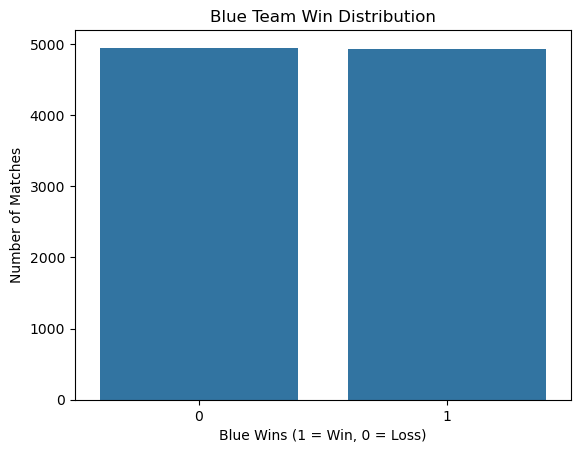

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x="blueWins", data=df)
plt.title("Blue Team Win Distribution")
plt.xlabel("Blue Wins (1 = Win, 0 = Loss)")
plt.ylabel("Number of Matches")
plt.show()


In [7]:
feasible_features = [
    "blueDragons",
    "blueHeralds",
    "blueTowersDestroyed",
    "redTowersDestroyed",
    "redHeralds",
    "redDragons"
]

df[feasible_features].describe()


,blueDragons,blueHeralds,blueTowersDestroyed,redTowersDestroyed,redHeralds,redDragons
count,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000
mean,0.361980,0.187974,0.051422,0.043021,0.160036,0.413098
std,0.480597,0.390712,0.244369,0.216900,0.366658,0.492415
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,4.000000,2.000000,1.000000,1.000000


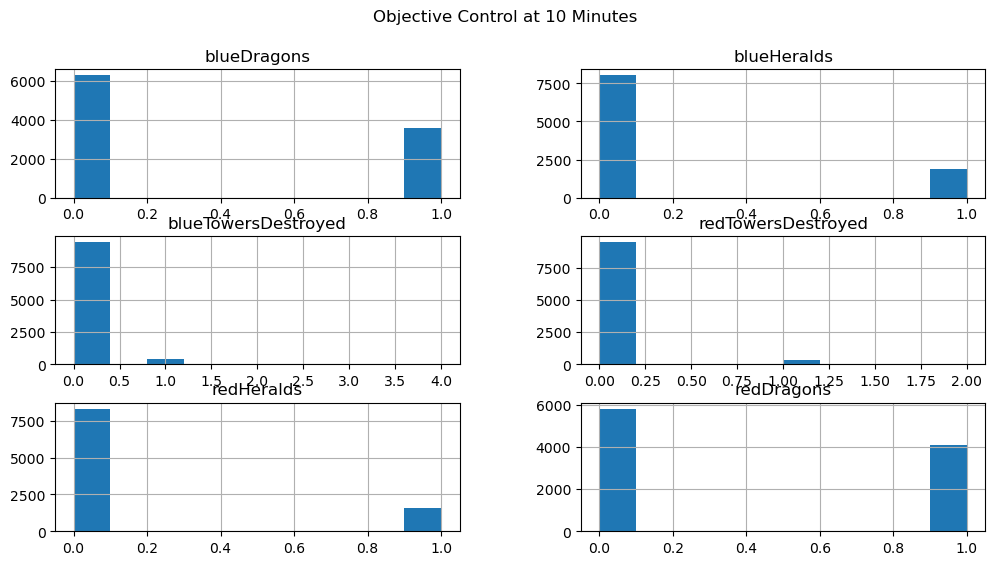

In [10]:
df[feasible_features].hist(bins=10, figsize=(12,6))
plt.suptitle("Objective Control at 10 Minutes")
plt.savefig("Objective Control at 10 Minutes.png", dpi=300, bbox_inches="tight")
plt.show()


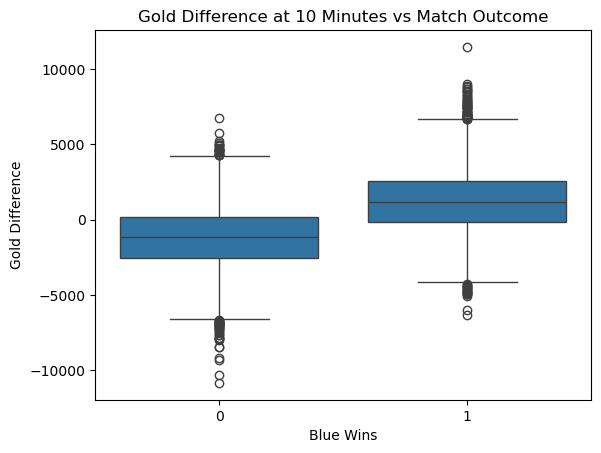

In [10]:
sns.boxplot(x="blueWins", y="blueGoldDiff", data=df)
plt.title("Gold Difference at 10 Minutes vs Match Outcome")
plt.xlabel("Blue Wins")
plt.ylabel("Gold Difference")
plt.show()


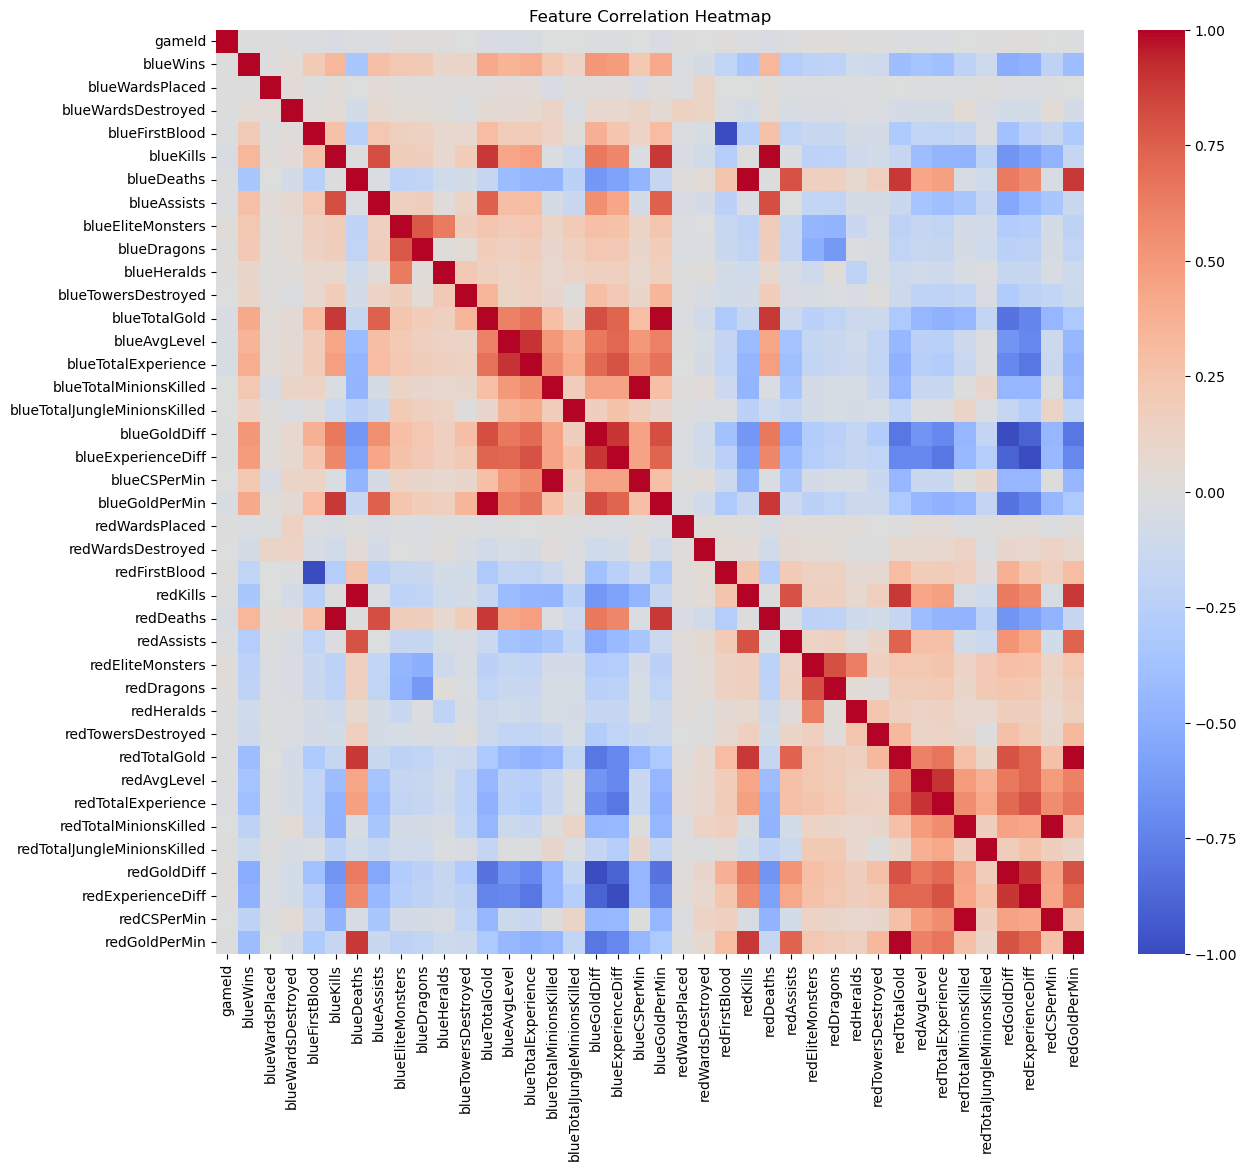

In [11]:
plt.figure(figsize=(14,12))
sns.heatmap(df.corr(), cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.savefig("my_plot.png", dpi=300, bbox_inches="tight")
plt.show()



## Preprocessing

- The target variable `blueWins` was separated from the feature set.
- The data was split into training and test sets to prevent data leakage.
- Feature scaling was applied using StandardScaler to normalize feature magnitudes.
- Scaling was fitted only on training data and applied to test data.


In [13]:
X = df.drop("blueWins", axis=1)
y = df["blueWins"]


In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)


In [19]:
accuracy = accuracy_score(y_test, y_pred)
accuracy


0.7160931174089069

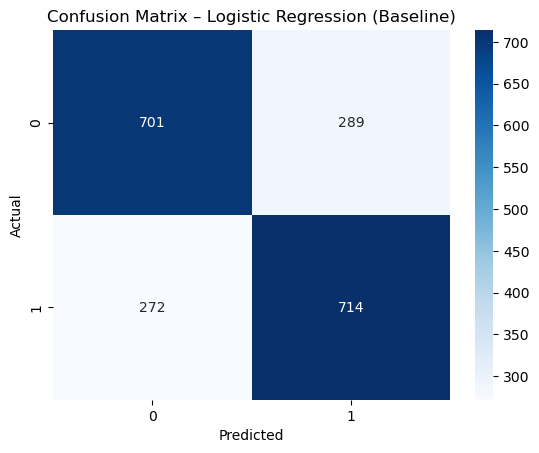

In [20]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix – Logistic Regression (Baseline)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [21]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.72      0.71      0.71       990
           1       0.71      0.72      0.72       986

    accuracy                           0.72      1976
   macro avg       0.72      0.72      0.72      1976
weighted avg       0.72      0.72      0.72      1976



In [22]:
coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": model.coef_[0]
}).sort_values(by="Coefficient", ascending=False)

coef_df.head(10)


,Feature,Coefficient
16,blueGoldDiff,0.285838
19,blueGoldPerMin,0.237571
11,blueTotalGold,0.237571
17,blueExperienceDiff,0.138327
8,blueDragons,0.113220
29,redTowersDestroyed,0.087099
34,redTotalJungleMinionsKilled,0.083507
25,redAssists,0.082010
37,redCSPerMin,0.067350
33,redTotalMinionsKilled,0.067350


## Baseline Model Interpretation

The Logistic Regression baseline shows that early-game gold difference and objective
control are strong predictors of match outcome. Importantly, feature interpretation
is constrained by the observed ranges at the 10-minute mark, ensuring that conclusions
remain feasible within game mechanics (e.g., at most one dragon can be secured).
